<div class="alert alert-warning">

**Disclaimer:**

This notebook is not maintained. The functionality presented here is not guaranteed to work with the latest version of eo-learn.   
</div>

# Land use and land cover (LULC) change mapping with deep learning

We constructed the workflow into three steps:

- **Step 1. Training data generation** from SentinelHub using eo-learn;

- **Step 2. Training model on the cloud** with fast.ai dynamic Unet;

- **Step 3. Prediction and model inference** 

The above steps were conceptionized from the current available [eo-learn usecase in the jupyter notebook](https://github.com/sentinel-hub/eo-learn/blob/934b4e6328706b4d44905d54e58b5fa7dc267ec1/examples/land-cover-map/SI_LULC_pipeline.ipynb) and the [blog post](https://medium.com/sentinel-hub/land-cover-classification-with-eo-learn-part-2-bd9aa86f8500). To understand the workflow deeply we recommend you go throught the usecase first. We adopted and moduelized the script to a workflow shows in the following diagram.


NOTE: The `fastai` Python library is required to run this notebook, but is not part of hte requirements of `eo-learn`. Make sure to install the library before running the notebook. 

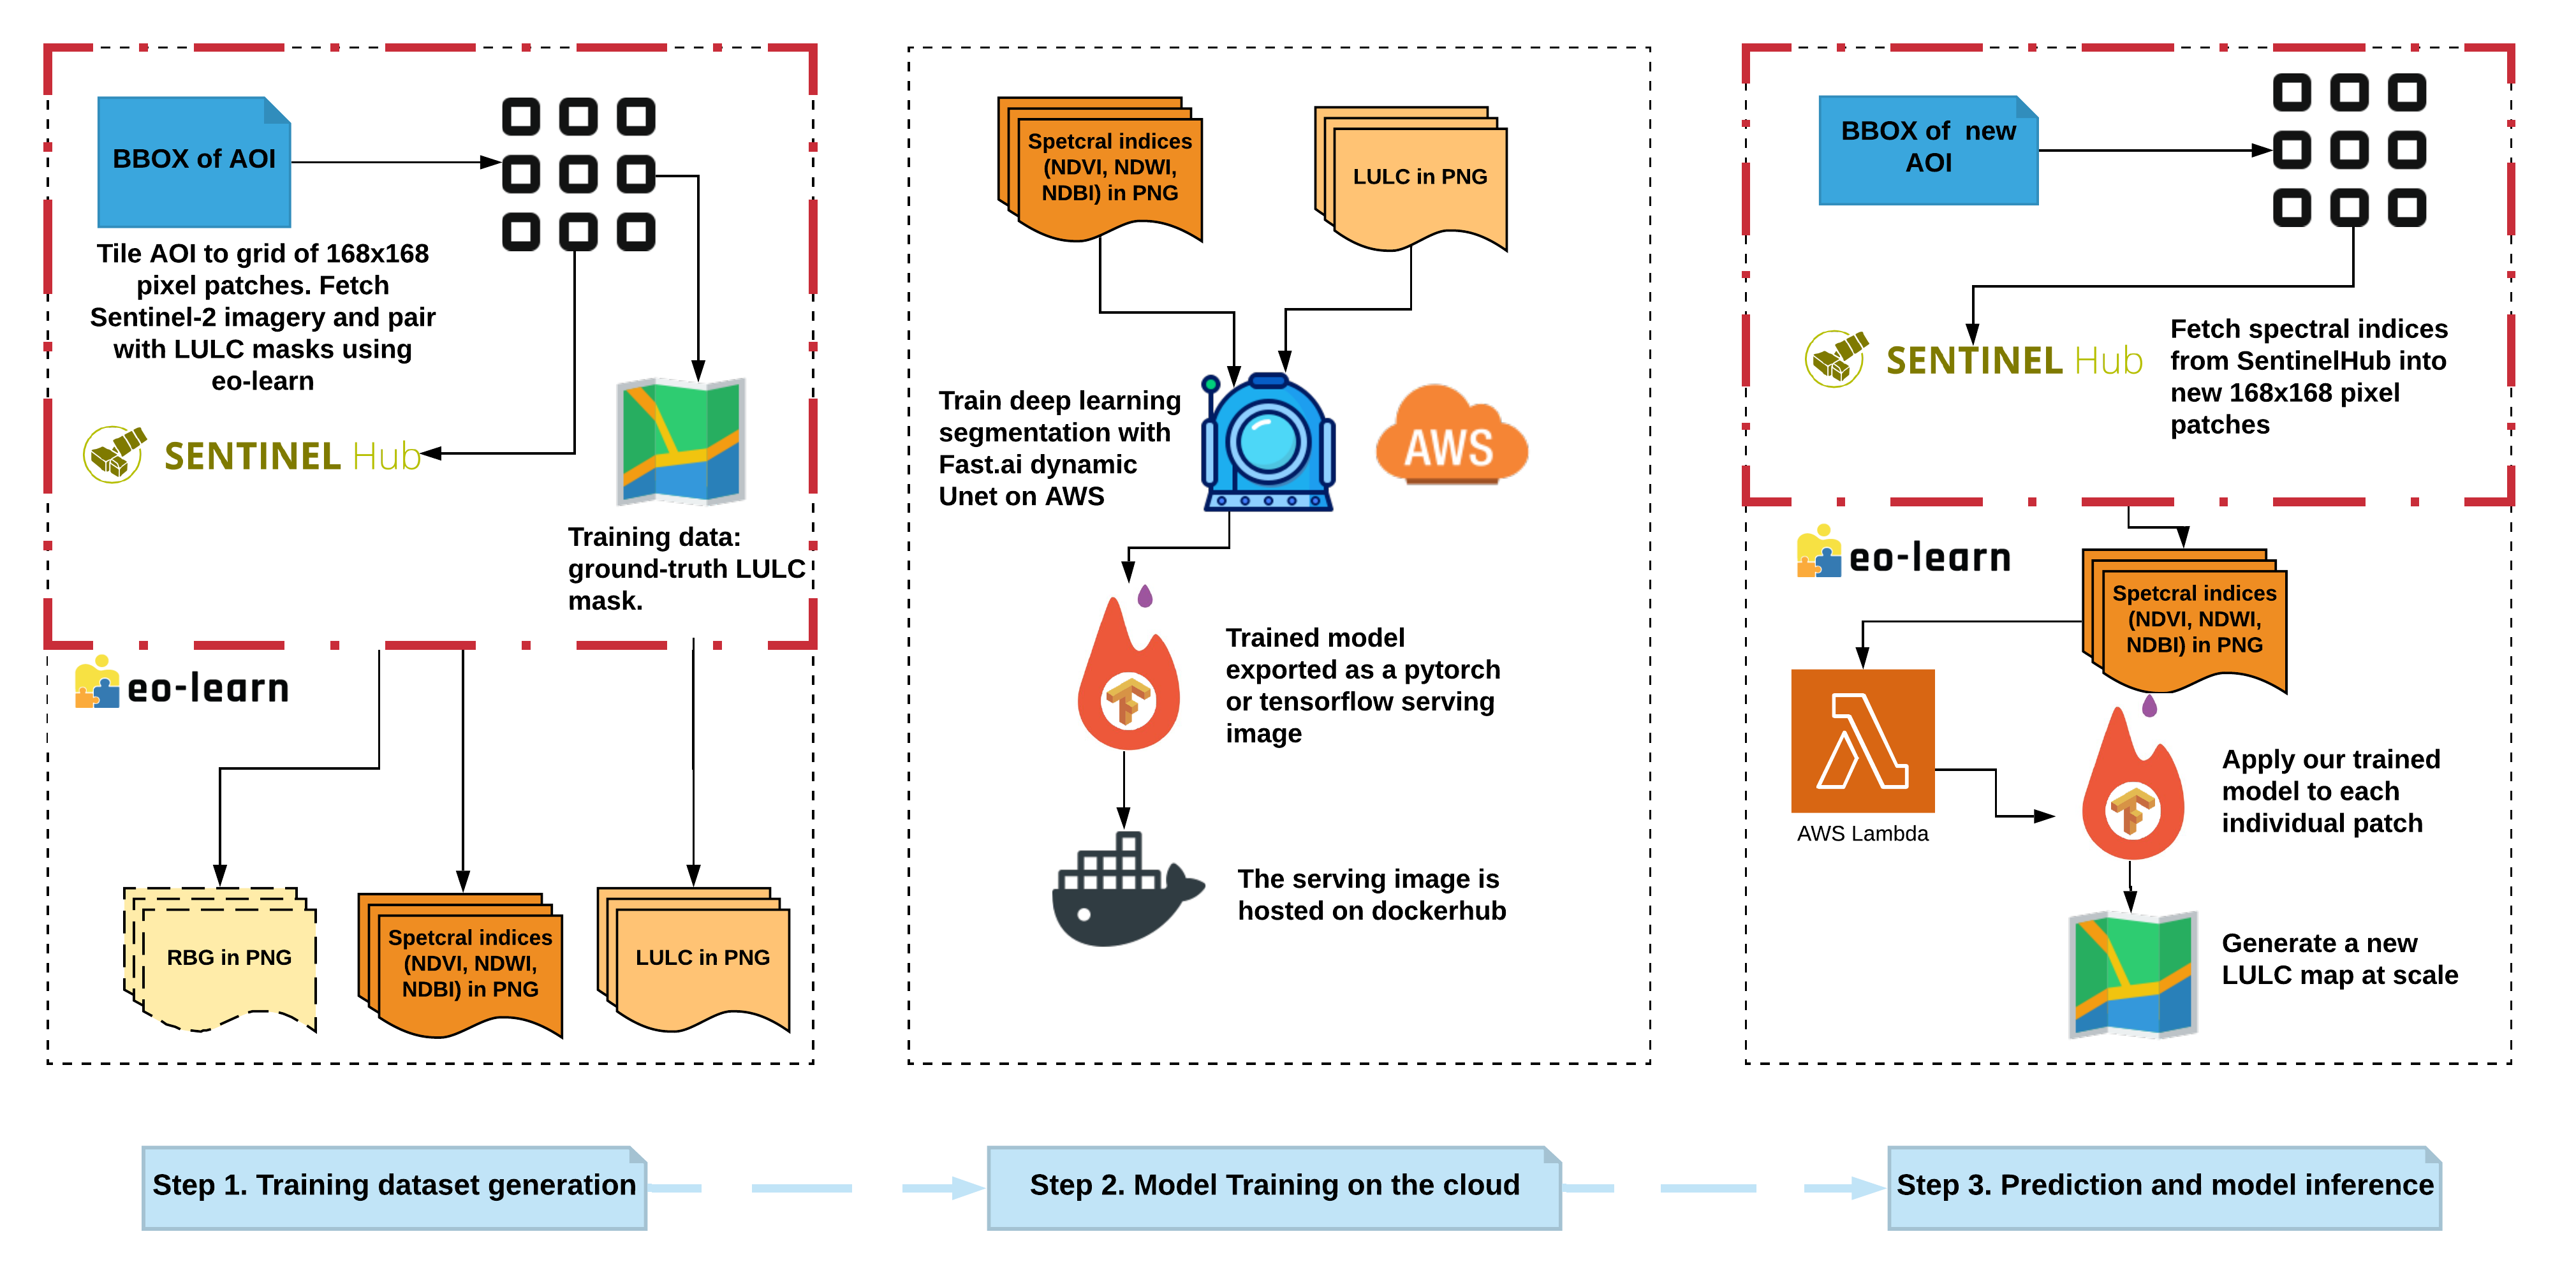

In [1]:
from IPython.display import Image
Image(filename='figures/deep_lulc_workflow.png')

**The diagram above shows the workflow for training a deep learning land use and land cover (LULC) using Sentinel-2 imagery.** 

The current model takes in three inputs, and they are:

- *BBOX of AOI*: bounding box of an area of interest either in ESRI shapefile or geojson format;
- *LULC mask*: Land use and land cover either in ESRI shapefile or geojson format;
- *BBOX of new AOI*: bounding box of a new area of interest to run the prediction or model inference. 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import shutil
import numpy as np
from os import makedirs, path as op
import datetime

from sentinelhub import BBoxSplitter, CRS, CustomUrlParam, DataCollection

from eolearn.core import FeatureType, SaveTask, AddFeature, OverwritePermission, LinearWorkflow, EOPatch
from eolearn.io import SentinelHubInputTask
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from eolearn.geometry import PointSamplingTask, ErosionTask, VectorToRaster

from utils.get_s2_sentinelhub import (SentinelHubValidData, CountValid, NormalizedDifferenceIndex, 
                                      ConcatenateData, ValidDataFractionPredicate)

from tqdm import tqdm_notebook as tqdm

import geopandas as gpd
from shapely.geometry import Polygon

# import computer vision from Fast.AI 
from fastai.vision import *
import fastai.callbacks.hooks 
import fastai.utils.mem
import enum
from PIL import Image

# for visualization of LULC and Sentinel-2 satellite imagery 
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def aoi_grid(shp, t_crs, gr_sz, save=False):
    """
    read in shape file and reproject it into the projection that will compute correct aoi size
    
    Args:
        shp: the AOI shapfile either in ESRI shapefile or geojson
        t_crs: the target coordination;
        gr_sz: tile/grid size to split the AOI, default is 168 by 168 pixels;
        save: save the generated AOI tile grid as a pickle file
    Return:
        patchID: the splitted tile that will be saved as EOpatch with the IDs

    Note:
        when save is set to Ture. An ESRI shapefile is saved to the disk under folder called "aoi_tile_grid"
    """
    #reading shapefile using geopandas
    aoi_geo = gpd.read_file(shp)
    #reproject the AOI to a target CRS that will give a correct AOI size in m2
    aoi_reprj = aoi_geo.to_crs(crs=t_crs.pyproj_crs())
    #get the AOI geometry
    aoi_shape = aoi_reprj.geometry.values[-1]
    # get the width and height (sentinel-2 in 10m resolution)
    s2_res = 10
    width_pix = int((aoi_shape.bounds[2] - aoi_shape.bounds[0])/s2_res)
    heigth_pix = int((aoi_shape.bounds[3] - aoi_shape.bounds[1])/s2_res)
    print('Dimension of the area is {} x {} pixels'.format(width_pix, heigth_pix))
    width_grid = int(round(width_pix/gr_sz))
    heigth_grid = int(round(heigth_pix/gr_sz))

    # split the tile grid by the desired grid number
    tile_splitter = BBoxSplitter([aoi_shape], t_crs, (width_grid, heigth_grid))
    print("The area is splitted into a grid with {} by {} tiles!".format(width_grid, heigth_grid))

    tiles = np.array(tile_splitter.get_bbox_list())
    info_list = np.array(tile_splitter.get_info_list())

    # get the all polygon information from the splitted AOI
    idxs_x = [info['index_x'] for info in tile_splitter.info_list]
    idxs_y = [info['index_y'] for info in tile_splitter.info_list]

    #save all the patch ID for tiles and save it as numpy array
    patchID = np.array(range(len(tiles))).astype("int")
    geometry = [Polygon(bbox_.get_polygon()) for bbox_ in tiles[patchID]]

    while save == True:
        # get the name of the file
        nm = shp.split("/")[-1]
        tile_path = "aoi_tile_grid"
        df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
        gdf = gpd.GeoDataFrame(df, crs=t_crs.pyproj_crs(), geometry= geometry)
        gdf.to_file(op.join(tile_path, nm))

    return patchID, tiles

In [4]:
def color_scale(arr):
    """correct the RGB bands to be a composed bands of value between 0 255 for visualization purpos
    
    Args:
        arr: RGB bands in numpy array 
    Return:
        arr: numpy array that values range from 0 to 255 for visualization
    """
    str_arr = (arr + 1) * 127.5
    return str_arr

def png_gen(patch, inference=False):
    """Save RGB, spectral info and labeled images for the coming deep learning
    
    Args:
        patch: Saved eopatches for deep learning LULC training and prediction 
    Return:
        None: images in the PNG.
    """
    
    patch_data = EOPatch.load(patch)
    bands = patch_data.data['FEATURES']
    patch_dir, patch_id = patch.split("/")
    if inference == True:
        inds_path = "inds_inference"

        if not op.isdir(inds_path):
            makedirs(inds_path)
        for i in range(len(bands)):
            #get NDVI, NDWI and NDBI from the bands
            inds = color_scale(bands[i][..., [-3, -2, -1]]).astype("uint8")
            Image.fromarray(inds).save(op.join(inds_path, patch+'_'+str(i)+'.png'))

    else:
        lulc = patch_data.mask_timeless['LULC']
        
        lulc_path = "lulc_all"
        rgb_path = "rgb_all"
        inds_path = "inds_all"
        if not op.isdir(lulc_path):
            makedirs(lulc_path)
        if not op.isdir(rgb_path):
            makedirs(rgb_path)
        if not op.isdir(inds_path):
            makedirs(inds_path)
        for i in range(len(bands)):
            # Switch R, G, B band index from bands
            rgb = color_scale(bands[i][..., [2, 1, 0]]).astype("uint8")
            inds = np.clip(color_scale(bands[i][..., [-3, -2, -1]]).astype("uint8"), 0, 255)
            Image.fromarray(rgb).save(op.join(rgb_path, "{}_{}.png".format(patch_id, str(i))))
            Image.fromarray(inds).save(op.join(inds_path, "{}_{}.png".format(patch_id, str(i))))
            Image.fromarray(lulc.astype("uint8").squeeze(-1), 'L').save(op.join(lulc_path, "{}_{}.png".format(patch_id, str(i))))

In [5]:
# Have a look of our training and test dataset. 

#training specific
train_shp = "../../example_data/land_cover_svn_fastai/large_training_aoi.geojson"
lulc_mask = "../../example_data/land_use_10class_reference_slovenia_partial.gpkg"
target_crs = CRS.UTM_33N
time_interval = ['2017-01-01', '2017-12-31']
lulc_codes = [1, 2, 3, 4, 5, 6, 8, 9] # land classes values taken from the above shapefile
grid_sz = 168 #the image size to train deep learning
inference = False 

#prediction and mode inference specific
test_shp = "../../example_data/land_cover_svn_fastai/large_test_aoi.shp" # switch to a smaller shapefile for visualization later
image_dir = "inds_all" #image tiles folder name
label_dir = "lulc_all" # label tiles folder name
lulc_code_f = "../../example_data/land_cover_svn_fastai/lulc_codes.txt" # save the land use and cover label in a text file for fast.ai deep learn to read 
valid_txt = "../../example_data/land_cover_svn_fastai/valid_18x18.txt"  # the tiles use to validate the model
train_1st = False # if it's a first train, False means the model is not trained from stratch.
inference = True # for prediction

model_weight = "stage-8-50-ind" # After the first train the model was saved under "inds_all/models/"
bs = 2 # model batch size

(361973.52363475441, 628376.85422626941, 5022218.2519783759, 5198861.540837544)

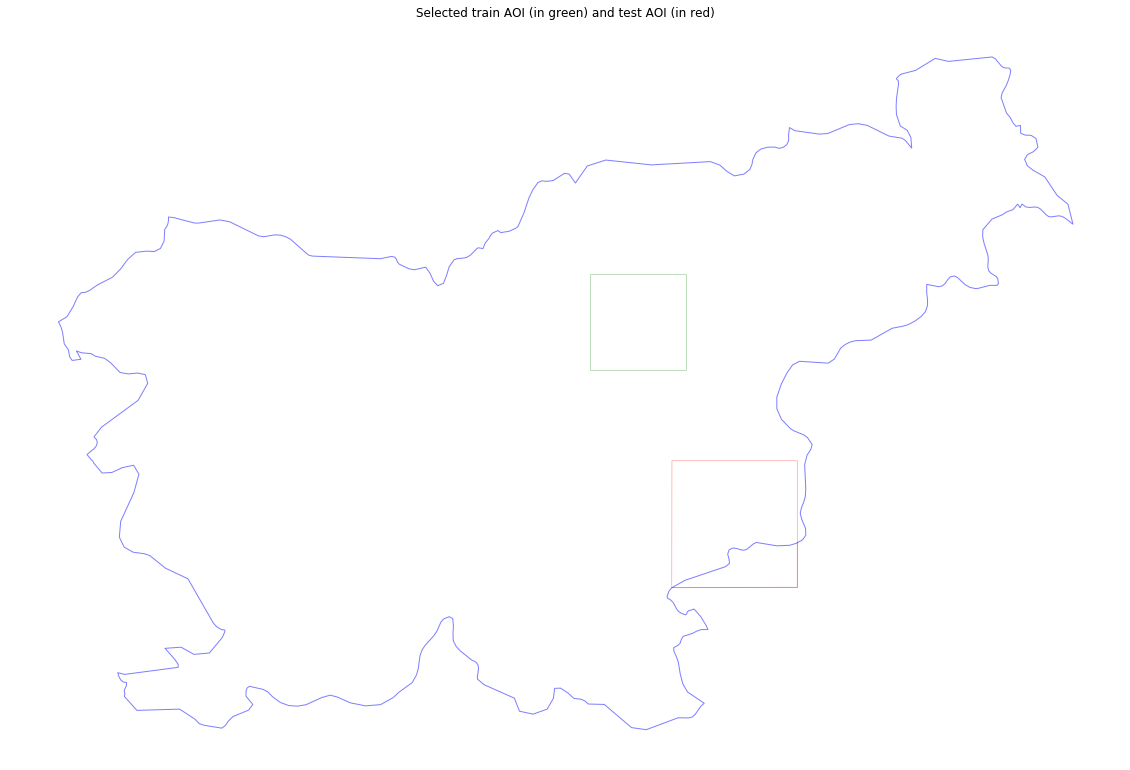

In [6]:
# Load geojson file
country = gpd.read_file('../../example_data/svn_border.geojson')
country_crs = target_crs


train_polyg = gpd.read_file(train_shp)
test_polyg = gpd.read_file(test_shp)

# reproject the polygons 
country = country.to_crs(crs=target_crs.pyproj_crs())
train_polyg = train_polyg.to_crs(crs=target_crs.pyproj_crs())
test_polyg = test_polyg.to_crs(crs=target_crs.pyproj_crs())

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

fig, ax = plt.subplots(figsize=(20, 20))
test_polyg.plot(ax=ax, facecolor='w', edgecolor='r', alpha=0.5) #test area in red
train_polyg.plot(ax=ax, facecolor='w', edgecolor='g', alpha=0.5) # train area in green
country.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5)
ax.set_title('Selected train AOI (in green) and test AOI (in red)');
plt.axis('off')

# Step 1. Training data generation

In [7]:
# fetch the Eopatch IDs along with tiles list from the input AOI for training
patchIDs, tile_list = aoi_grid(train_shp, target_crs, grid_sz, save=False)

print("Extracting the dataset from SentinelHub with eo-learn:")
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. The SentinelHub cloud mask and probas are downloaded as well
add_data = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B02','B03','B04','B08','B11','B12'],
    bands_feature=(FeatureType.DATA, 'BANDS'),
    additional_data=[(FeatureType.MASK, 'CLM'), (FeatureType.MASK, 'dataMask'), (FeatureType.DATA, 'CLP')],
    resolution=10,
    maxcc=.8,
    time_difference=datetime.timedelta(hours=2)
)

#[B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2]


# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
ndbi = NormalizedDifferenceIndex('NDBI', 'BANDS/4', 'BANDS/3')
# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NDBI'])
# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 99 % valid coverage
valid_pixels = 0.99
valid_data_predicate = ValidDataFractionPredicate(valid_pixels)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampling = 16 
resampled_range = (time_interval[0], time_interval[1], resampling)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range # set the resampling range
)
# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, 'LULC', 'LULC_ERODED'), disk_radius=1)
# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = int(1e5) # no. of pixels to sample

spatial_sampling = PointSamplingTask(
    n_samples=n_samples,
    ref_mask_feature='LULC_ERODED',
    ref_labels=lulc_codes,
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
    ])

lulc = gpd.read_file(lulc_mask)
add_lulc = VectorToRaster(vector_input=lulc, 
                          raster_feature=(FeatureType.MASK_TIMELESS, 'LULC'),
                          values_column='lulcid',
                          raster_resolution=(10,10))

path_out_sampled = 'eopatches_sampled_Slovenia/'
if not op.isdir(path_out_sampled):
    makedirs(path_out_sampled)
save_s2 = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
workflow = LinearWorkflow(
        add_data,
        ndvi,
        ndwi,
        ndbi,
        add_sh_valmask,
        count_val_sh,
        add_lulc,
        concatenate,
        filter_task,
        linear_interp,
        erosion,
        spatial_sampling,
        save_s2)


Dimension of the area is 2300 x 2300 pixels
The area is splitted into a grid with 14 by 14 tiles!
Extracting the dataset from SentinelHub with eo-learn:


In [8]:
# replace the SentinelHub configure with your python template id here
#!sentinelhub.config --instance_id INSTANCE_ID

In [9]:
#download eopatch for the desired AOI and covert the numpy array into RGB, spectral info (NDVI, NDWI, NDBI) 
# and training lulc label into PNG and saved them under "rgb_all", "inds_all" and "lulc_all"
pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(tile_list[patchIDs]):
    # define additional parameters of the workflow
    extra_param = {
        add_data: {'bbox': bbox, 'time_interval': time_interval},
        save_s2: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }

    workflow.execute(extra_param)
    png_gen(op.join(path_out_sampled, 'eopatch_{}'.format(idx)), inference=False)
    shutil.rmtree(op.join(path_out_sampled, 'eopatch_{}'.format(idx)), ignore_errors=True)
    pbar.update(1)

# Step 2. Training model on the cloud

In [10]:
# compute the stats for our training dataset instead of using ImageNet dataset stats
TRAIN = Path(image_dir)
images = (plt.imread(str(i)) for i in TRAIN.iterdir()) # generator comprehension
images = np.stack(images) 
means = np.mean(images, axis=(0, 1, 2))
stds = np.std(images, axis=(0, 1, 2))
new_stats = (list(means), list(stds))

In [29]:
def iou(input_, target):
    codes = np.loadtxt(lulc_code_f, dtype=str)
    target = target.squeeze(1)
    name2id = {v:k for k,v in enumerate(codes)}
    void_code = name2id['NoData']
    mask = target != void_code
    return (input_.argmax(dim=1)[mask] == target[mask]).float().mean()

def train(image_path, label_path, lulc_code_f, valid_txt_f, train_bol, model_weight, bach_size):
    lbl_names = get_image_files(label_path)
    img_f = lbl_names[0]
    mask = open_mask(img_f)
    src_size = np.array(mask.shape[1:])
    ### above image size is in shape (168, 166, 3), but feel free to us other image shape in even number
    if list(src_size) != [168, 166]:
        src_size = np.array([168, 166])
    codes = np.loadtxt(lulc_code_f, dtype=str)
    get_y_fn = lambda x: label_path+f'/{x.stem}.png'
    valid_f = open(valid_txt_f, "r").read().split()
    src = (SegmentationItemList.from_folder(image_path).split_by_files(valid_f).label_from_func(get_y_fn, classes=codes))
    # create data bantch that normalize by 
    data = (src.transform(get_transforms(do_flip=True, max_rotate=1.5, max_zoom=20.0, p_affine=0.75), 
                          size=src_size, tfm_y=True).databunch(bs=bach_size).normalize(new_stats))
    name2id = {v:k for k, v in enumerate(codes)}
    void_code = name2id['NoData']

    metrics = iou
    wd = 1e-2

    learner = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)
    lr = 1e-4
    if train_bol == False:
        lrs = slice(lr/400, lr/4)
        learner.unfreeze()
        learner.load(model_weight);

    else:
    ##if it's trained the first time, we recommend you to search for learning rate (lr) with the training dataset
    ## with lesly smith lr founder in fast.ai.
    ## uncomment and run the following two code to find the lr othervise the default learning rate will be 1e-4
    #lr_find(learner)
    #learner.recorder.plot()
    ## loading the model resnet50 as the encoder
        #train the model for 50 iterations
        learner.fit_one_cycle(10, slice(lr), pct_start=0.8)
        learner.save('stage-1-50-ind')
        lrs = slice(lr/400, lr/4)
        learner.unfreeze()
        learner.fit_one_cycle(30, lrs, pct_start=0.8)
        learner.save('stage-2-50-ind')
        learner.fit_one_cycle(30, lrs, pct_start=0.8)
        learner.save('stage-3-50-ind')
        model_weigh = 'stage-3-50-ind'
    return learner, model_weigh

In [ ]:
# Training a LULC model from scratch for the first time, uncomment the following script
# train_1st=True
# model_weight=None
# res50_unet, model_weigh = train(image_dir, label_dir, lulc_code_f, valid_txt, train_1st, model_weight, bs)

# Step 3. Prediction and model inference

In [13]:
linear_interp_infer = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    resample_range=resampled_range # set the resampling range
)

In [ ]:
#for visualization purpose I replace the test area with a much smaller area
test_shp = "../../example_data/land_cover_svn_fastai/small_test_aoi.shp"
patchIDs, tile_list = aoi_grid(test_shp, target_crs, grid_sz, save=False)
path_out_inference = './eopatches_sampled_inference_small/'
train_1st = False
image_dir = "inds_all"
label_dir = "lulc_all"
# model_weight = "inds_all/models/stage-8-50-ind.pth"

if not op.isdir(path_out_inference):
    makedirs(path_out_inference)
save_s = SaveTask(path_out_inference, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
workflow = LinearWorkflow(
        add_data,
        ndvi,
        ndwi,
        ndbi,
        add_sh_valmask,
        count_val_sh,
        concatenate,
        filter_task,
        linear_interp_infer,
        save_s)

In [ ]:
pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(tile_list[patchIDs]):
    extra_param = {
        add_data: {'bbox': bbox, 'time_interval': time_interval},
        save_s: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }

    workflow.execute(extra_param)
    print("eopatch {} has been processed!".format(idx))
    png_gen(op.join(path_out_inference, 'eopatch_{}'.format(idx)), inference)
    print("Inds PNG to eopatch_{} for the coming inference pipeline".format(idx))

    pred_path = "pred_inference"
    if not op.isdir(pred_path):
        makedirs(pred_path)
    if inference == True:
        inf_path = op.join(path_out_inference, 'eopatch_{}'.format(idx))
    else: inf_path = "inds_all"
    tfnames = get_image_files(inf_path)
    pred_out = list()
    for fname in tfnames:
        name = str(fname).split("/")[1]
        img = open_image(fname)
        pred_img = res50_unet.predict(img)
        pred_arr = np.squeeze(np.array(pred_img[1]))
        pred_arr_ = np.expand_dims(pred_arr, 2)
        pred_out.append(pred_arr_)
    print("ML prediction for eopath_{} is saved".format(idx))
    patch_data = EOPatch.load(op.join(path_out_inference, 'eopatch_{}'.format(idx)))
    pred = np.array(pred_out)
    predicted_label = "LULC_PRED"
    patch_data.add_feature(FeatureType.MASK_TIMELESS, predicted_label, pred)

    print(np.array(pred_out).shape, np.array(pred_out).mean())
    np.savez('eopatch_{}_out.npz'.format(idx), prediction=pred)

    patch_data.save(op.join(path_out_inference,'eopatch_{}/'.format(patchid)), 
                    overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)
    pbar.update(1)

In [ ]:
class LULC(enum.Enum):
    NO_DATA = (0, 'No Data', 'white')
    CULTIVATED_LAND = (1, 'Cultivated Land', 'xkcd:lime')
    FOREST = (2, 'Forest', 'xkcd:darkgreen')
    GRASSLAND = (3, 'Grassland', 'orange')
    SHRUBLAND = (4, 'Shrubland', 'xkcd:tan')
    WATER = (5, 'Water', 'xkcd:azure')
    WETLAND = (6, 'Wetlands', 'xkcd:lightblue')
    TUNDRA = (7, 'Tundra', 'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8, 'Artificial Surface', 'crimson')
    BARELAND = (9, 'Bareland', 'xkcd:beige')
    SNOW_AND_ICE = (10, 'Snow and Ice', 'black')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3   
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

In [ ]:
poly = test_polyg['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

In [ ]:
#result visulization
# Draw the RGB image
path_out = './eopatches_sampled_inference_small'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

# Eopatch ID order from top left to bottom right.
EopatchID = [4, 9, 14, 19, 24, 3, 8, 13, 18, 23, 2, 7, 12, 17, 22, 1, 6, 11, 16, 21, 0, 5, 10, 15, 20]
# Draw the prediction images
fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=5, ncols=5)

#We have 23 tiles saves for each Eopatch, and use index =10, it falls around ealier summer time. 
date_indx = 10 
for i, ax in zip(EopatchID, axes.flatten()):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(np.clip(eopatch.data['FEATURES'][date_indx][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

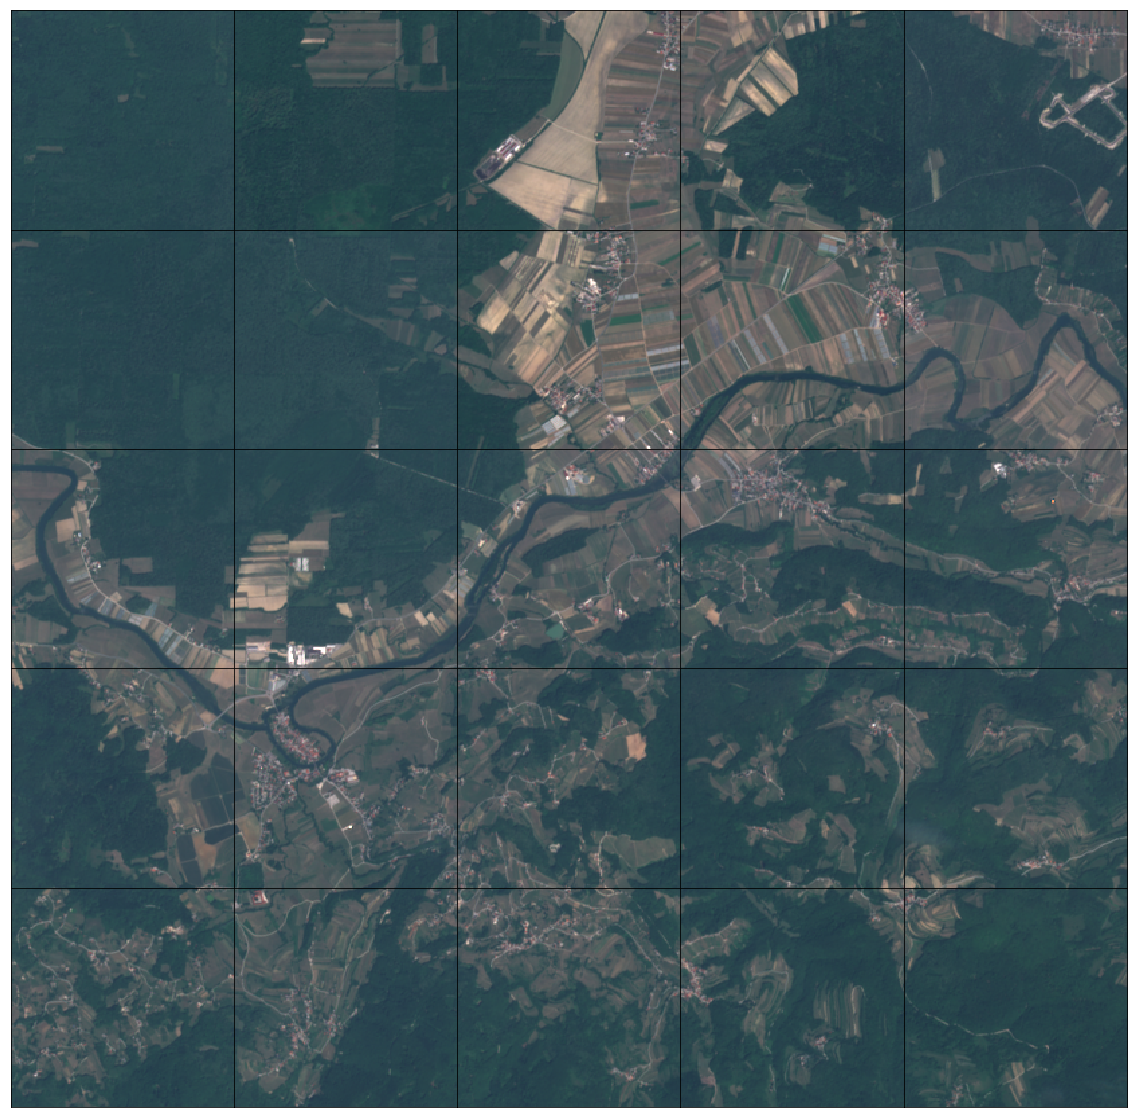

In [2]:
from IPython.display import Image
Image(filename='figures/rgb-lulc-fastai.png')

In [ ]:
# Draw the prediction images
fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=5, ncols=5)

for i, ax in zip(EopatchID, axes.flatten()):
    eopatch = np.load('eopatch_{}_out.npz'.format(i))['prediction'][date_indx]
    im = ax.imshow(eopatch.squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

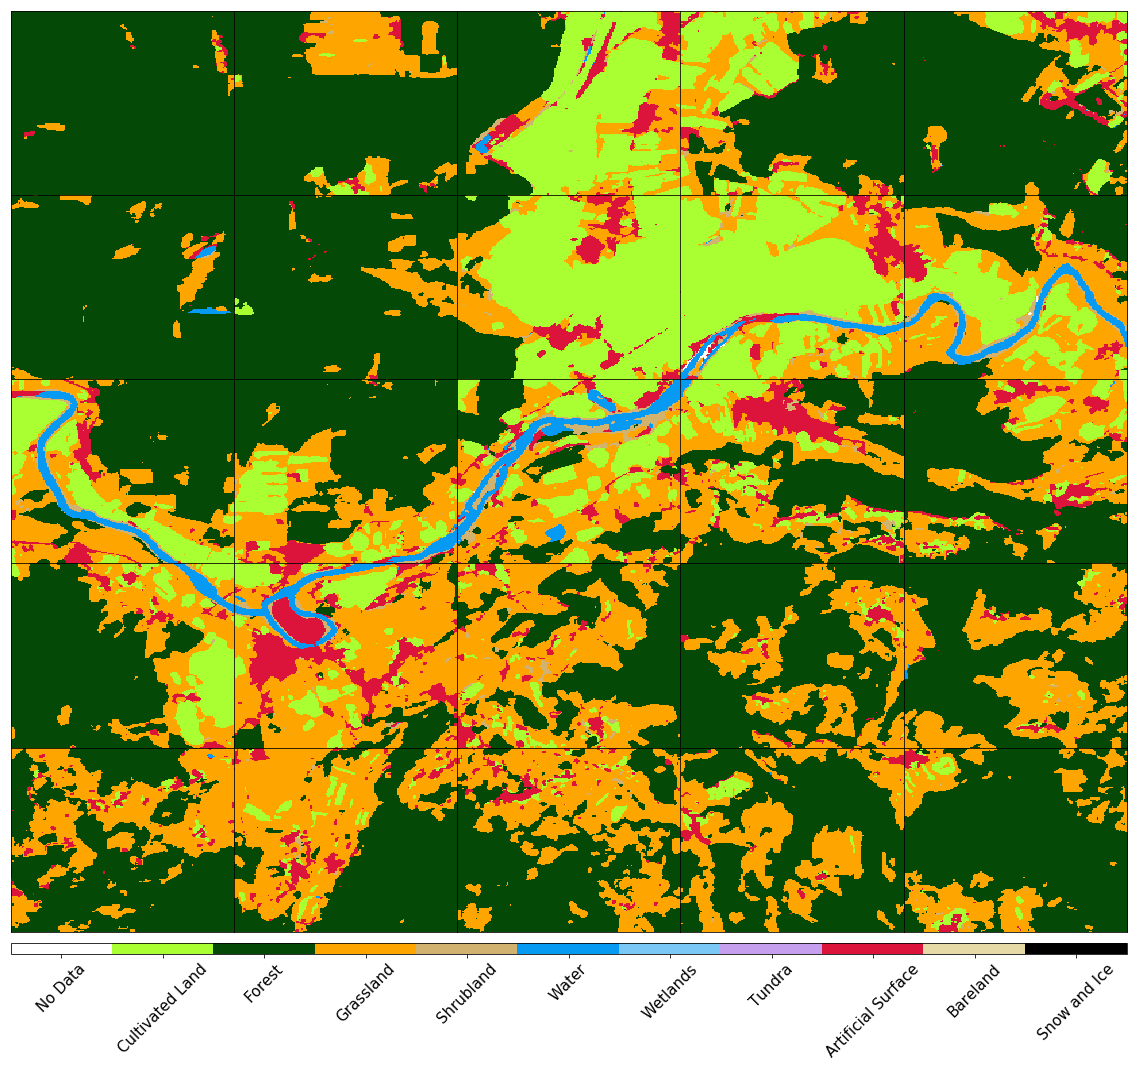

In [3]:
from IPython.display import Image
Image(filename='figures/prediction-lulc-fastai.png')